# Coverage Map

In [ ]:
import pandas as pd

program_data = pd.read_csv("us_program_data.csv", encoding="latin1")

# Group by state and count # of programs
state_program_counts = program_data.groupby('state').size().reset_index(name='num_programs')
result = state_program_counts.copy()

# Create a list of all US states you want to include
all_states = ['KS', 'LA', 'ME', 'NV', 'RI', 'WY']

# Combine the existing states with the new states and sort alphabetically
combined_states = sorted(set(result['state'].tolist() + all_states))

# Reindex the DataFrame to include all states, filling new rows with NaN
result_with_all_states = result.set_index('state').reindex(combined_states).reset_index()

# Sort the DataFrame by state
result_with_all_states = result_with_all_states.sort_values('state')

# Display the resulting dataset
print(result_with_all_states)

# Display the updated dataset
print(result_with_all_states)

max_prices_and_penalties = result_with_all_states


   state  num_programs
0     AK           1.0
1     AL           2.0
2     AR           4.0
3     AZ           4.0
4     CA          16.0
5     CO          14.0
6     CT           2.0
7     DC           1.0
8     DE           1.0
9     FL           2.0
10    GA           1.0
11    HI           2.0
12    IA           2.0
13    ID           2.0
14    IL           1.0
15    IN           9.0
16    KS           NaN
17    KY           2.0
18    LA           NaN
19    MA           2.0
20    MD           1.0
21    ME           NaN
22    MI           1.0
23    MN           3.0
24    MO           1.0
25    MS           1.0
26    MT           2.0
27    NC           9.0
28    ND           4.0
29    NE           7.0
30    NH           1.0
31    NJ           1.0
32    NM          14.0
33    NV           NaN
34    NY           2.0
35    OH           1.0
36    OK           1.0
37    OR           1.0
38    PA           1.0
39    RI           NaN
40    SC           5.0
41    SD           2.0
42    TN   

In [5]:
import os
import geopandas as gpd

# Define the folder and file name
folder_path = r"c:\Users\juzzz\Desktop\GitHub\dr-programs\analysis\cb_2018_us_state_500k"
file_name = "cb_2018_us_state_500k.shp"

# Construct the full file path
file_path = os.path.join(folder_path, file_name)

# Check if the file exists
if os.path.exists(file_path):
    try:
        # Try to read the shapefile to ensure it's usable
        us_states = gpd.read_file(file_path)
        print(f"File '{file_name}' exists and is usable.")
    except Exception as e:
        print(f"File '{file_name}' exists but is not usable. Error: {e}")
else:
    print(f"File '{file_name}' does not exist in the folder '{folder_path}'.")

File 'cb_2018_us_state_500k.shp' exists and is usable.


File exists


C:\Users\juzzz\AppData\Local\Temp\ipykernel_14032\3816182913.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap)
c:\Users\juzzz\miniconda3\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\juzzz\AppData\Local\Temp\ipykernel_14032\3816182913.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


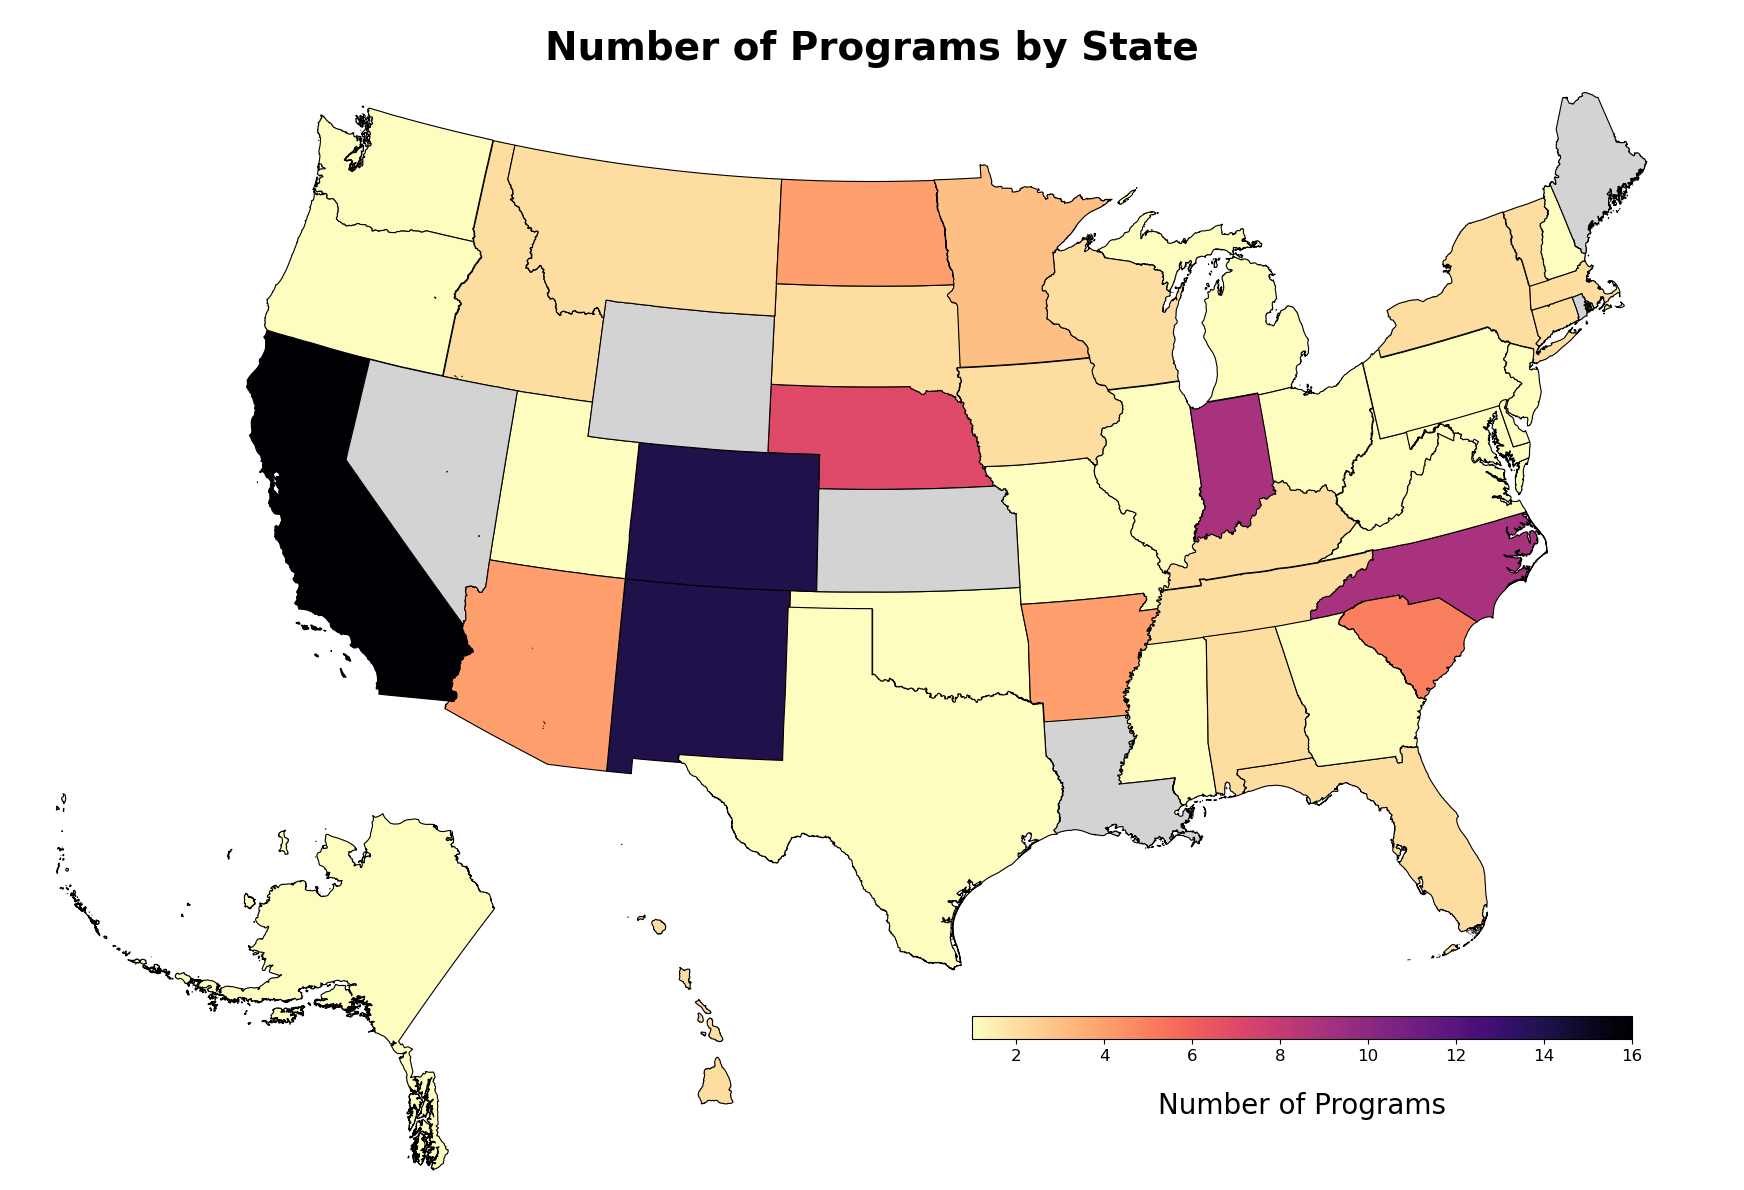

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Name map file
map_file = "cb_2018_us_state_500k/cb_2018_us_state_500k.shp"

# Check if the file exists
if os.path.exists(map_file):
    print("File exists")
else:
    print("File does not exist")

# Read the shapefile
us_states = gpd.read_file(map_file)

# Remove territories and keep only 50 states
us_states = us_states[us_states['STUSPS'].isin(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
                                                'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
                                                'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
                                                'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
                                                'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'])]


# Merge program counts with shapefile data
merged_data = us_states.merge(state_program_counts, left_on='STUSPS', right_on='state', how='left')

# Define makeColorColumn to assign colors based on a column's values
def makeColorColumn(data, column, vmin, vmax, cmap='viridis'):
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.cm.get_cmap(cmap)
    data['value_determined_color'] = data[column].apply(lambda x: mcolors.to_hex(cmap(norm(x))) if pd.notnull(x) else '#d3d3d3')
    return data

# Replace the price-related columns with the number of programs
def create_map(data, column, title, cmap='viridis'):
    # Set parameters
    variable = column
    vmin, vmax = data[column].min(), data[column].max()
    data = makeColorColumn(data, variable, vmin, vmax, cmap=cmap)

    # Create "visframe" as a re-projected GeoDataFrame using EPSG 2163 for CONUS
    visframe = data.to_crs({'init': 'epsg:2163'})

    # Create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(20, 12))
    ax.axis('off')

    from shapely.affinity import translate

    # Plot CONUS states (excluding Alaska and Hawaii)
    for row in visframe.itertuples():
        if row.STUSPS not in ['AK', 'HI']:
            vf = visframe[visframe['STUSPS'] == row.STUSPS]
            c = data[data['STUSPS'] == row.STUSPS]['value_determined_color'].iloc[0]
            vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor="black")

    # Set limits for continental US
    ax.set_xlim(-2800000, 2800000)
    ax.set_ylim(-2800000, 1000000)

    # Add Alaska (scaled and repositioned)
    alaska = visframe[visframe['STUSPS'] == "AK"].scale(xfact=0.50, yfact=0.50, origin=(0, 0))
    alaska = alaska.translate(xoff=-470000, yoff=-3500000)
    alaska.plot(color=data[data["STUSPS"] == "AK"]["value_determined_color"].iloc[0],
                linewidth=0.8, ax=ax, edgecolor="black")

    # Add Hawaii (scaled and repositioned)
    hawaii = visframe[visframe['STUSPS'] == "HI"].scale(xfact=1, yfact=1, origin=(0, 0))
    hawaii = hawaii.translate(xoff=5000000, yoff=-1500000)
    hawaii.plot(color=data[data["STUSPS"] == "HI"]["value_determined_color"].iloc[0],
                linewidth=0.8, ax=ax, edgecolor="black")

    # Add a title to the map
    ax.set_title(f"{title}", fontsize=28, y=0.95, x=0.5, fontweight="bold")

    # Add colorbar legend to the side
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar_ax = fig.add_axes([0.55, 0.13, 0.33, 0.019])
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
    cbar.set_label("Number of Programs", rotation=0, labelpad=20, fontsize=20)
    cbar.ax.tick_params(labelsize=12)

    plt.tight_layout()
    plt.show()

# Create a map showing the number of programs in each state
create_map(merged_data, "num_programs", "Number of Programs by State", cmap="magma_r")

